# 04)Amazon Beauty Product Recommender System - Word2vec

In this notebook, we will build our word embeddings with the Word2vec model and the following topics will be covered here
- What is Word2vec?
- Building the model
- Visualizing the embeddings
- Word2vec + Cosine Similarities
- Conclusion
- Future Works

# What is Word2vec?

Word2vec is a simple neural network model with a single hidden layer. Unlike a regular neutral network model where we are interested in the output layer, the value in Word2vec comes from the single hidden layer where the weights are obtained and can be used as word embeddings. Training a corpus with Word2vec means that each word in the vocabulary is a point on a vector in an n-dimension pane.

Unlike TF-IDF and Count Vectorizer bag of words methodology, Word2vec is able to obtain context from any given sentence and is good at capturing semantic meaning and relationships.

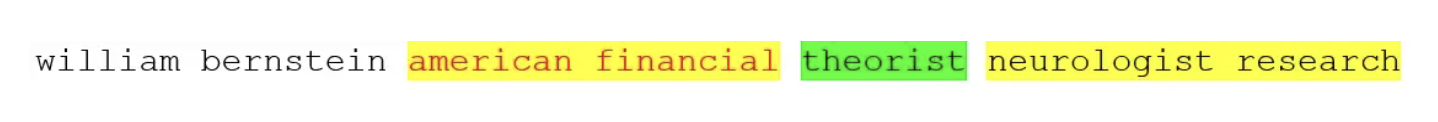

In the above sentence, the input word is **"theorist"**, and the surrounding words highlighted in yellow are the words in the context window. The model is essentially picking the words in the context window one by one and finding the probability of every word in the vocabulary being the selected adjacent word.

There are two architectures within Word2vec used to train our model. **CBOW (Continuous Bag Of Words)** and **Skip-gram**.
In the CBOW model, the distributed representations of context (or surrounding words) are combined to predict the word in the middle. While in the Skip-gram model, the distributed representation of the input word is used to predict the context.

**Skip-gram**: works well with a small amount of the training data, represents well even rare words or phrases.

**CBOW**: several times faster to train than the skip-gram, slightly better accuracy for the frequent words.

In this project, we will be using the CBOW architecture to train our model.

Training our own word embeddings expensive process and also needs large datasets. But this can be overcome by using a pretrained model. I used Google pre-trained word embeddings which were trained on a large corpus, such as Wikipedia, news articles, etc.

The pre-trained embeddings helped to get the vectors for the words I want. It is a large collection of key-value pairs, where keys are the words in the vocabulary and values are their corresponding word vectors.

# Building the model

## Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import requests
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer # RegexpTokenizer uses regex for tokenization
from nltk.stem import WordNetLemmatizer # for lemmatization
from nltk.stem.porter import PorterStemmer # for stemming
from nltk.corpus import stopwords # for stopwords removal
import re
import nltk
from nltk.probability import FreqDist

from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

import multiprocessing

#Word embeddings visualizations
import plotly
import plotly.graph_objs as go
from sklearn.manifold import TSNE

In [2]:
df = pd.read_pickle("dataset/df_for_model.pkl")

In [3]:
df.head(3)

,product_description,product,brand,price,imageURLHighRes,reviewer_score,reviewerID,review,average_reviewer_score,combined_text,cleaned,lemmatized_words,lemmatized_text
productID,,,,,,,,,,,,,
6546546450,[Loud 'N Clear Personal Sound Amplifier allows...,Loud 'N Clear&trade; Personal Sound Amplifier,idea village,,[],4.0,A3349A7IGM954K,"Better amplification, better battery life than...",2.5,Loud 'N Clear Personal Sound Amplifier allows ...,loud n clear personal sound amplifier allows t...,"[loud, n, clear, personal, sound, amplifier, a...",loud n clear personal sound amplifier allows t...
7178680776,[No7 Lift & Luminate Triple Action Serum 50ml ...,No7 Lift &amp; Luminate Triple Action Serum 50...,,$44.99,[],3.0,A3Q0QXUKRGACMU,I've been using it for just about 3 weeks. I t...,3.0,No7 Lift & Luminate Triple Action Serum 50ml b...,no7 lift luminate triple action serum 50ml boo...,"[no7, lift, luminate, triple, action, serum, 5...",no7 lift luminate triple action serum 50ml boo...
7250468162,[No7 Stay Perfect Foundation now stays perfect...,No7 Stay Perfect Foundation Cool Vanilla by No7,No7,$28.76,[],5.0,A3MQI5EJSEDO1K,It's difficult to find sometimes so I'm glad t...,5.0,No7 Stay Perfect Foundation now stays perfect ...,no7 stay perfect foundation stays perfect long...,"[no7, stay, perfect, foundation, stay, perfect...",no7 stay perfect foundation stay perfect longe...


In [4]:
corpus = []
for words in df['cleaned']:
    corpus.append(words.split())

#### Load our pretrained word2vec model by google

In [5]:
#Load our pretrained word2vec model by google
EMBEDDING_FILE = 'model/GoogleNews-vectors-negative300.bin.gz'
google_word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [6]:
# Training our corpus with Google Pretrained Model

google_model = Word2Vec(vector_size = 300, window=5, min_count = 1, workers = multiprocessing.cpu_count(),sg=0)
google_model.build_vocab(corpus)

#model.intersect_word2vec_format('./word2vec/GoogleNews-vectors-negative300.bin', lockf=1.0, binary=True)

google_model.wv.load_word2vec_format(EMBEDDING_FILE,binary=True)

google_model.train(corpus, total_examples=google_model.corpus_count, epochs = 5)

(5069783, 5324565)

#### We have now trained our corpus with Google's pretrained Word2vec model, we shall see the similarities by inputting random words

In [7]:
google_model.wv.most_similar(positive=["powder"])

[('blush', 0.8889005780220032),
 ('bare', 0.8785225749015808),
 ('primer', 0.8588020205497742),
 ('foundation', 0.8532168865203857),
 ('beauticontrol', 0.8439345359802246),
 ('escentuals', 0.8423675894737244),
 ('puff', 0.8343104720115662),
 ('bareminerals', 0.8281928300857544),
 ('mattifying', 0.8255890011787415),
 ('baked', 0.8255589008331299)]

In [8]:
google_model.wv.most_similar(positive=["bottle"])

[('bottles', 0.9233996868133545),
 ('vials', 0.8794776797294617),
 ('dropper', 0.838443398475647),
 ('roll', 0.8148881196975708),
 ('pump', 0.806883692741394),
 ('anoint', 0.8027731776237488),
 ('jar', 0.7993531227111816),
 ('hdpe', 0.7791951894760132),
 ('sprayer', 0.7720285058021545),
 ('refillable', 0.7718221545219421)]

In [9]:
google_model.wv.most_similar(positive=["birthday"])

[('christmas', 0.9585855603218079),
 ('anniversary', 0.9574587941169739),
 ('graduation', 0.941746711730957),
 ('bachelorette', 0.9319109916687012),
 ('anniversaries', 0.9263964295387268),
 ('prom', 0.9238927364349365),
 ('wedding', 0.921150803565979),
 ('weddings', 0.9161752462387085),
 ('parties', 0.9144466519355774),
 ('party', 0.9138889312744141)]

In [10]:
google_model.wv.most_similar(positive=["shampoo"])

[('conditioner', 0.9418206810951233),
 ('cowash', 0.8805296421051025),
 ('devacurl', 0.8206061720848083),
 ('bodywash', 0.8106886744499207),
 ('mielle', 0.8105886578559875),
 ('replenisher', 0.8080236911773682),
 ('900ml', 0.8057024478912354),
 ('ndash', 0.8035198450088501),
 ('detangler', 0.8023478388786316),
 ('tsubaki', 0.7985059022903442)]

In [11]:
google_model.wv.most_similar(positive=["bad"])

[('germs', 0.9632314443588257),
 ('breath', 0.9605050683021545),
 ('cavities', 0.925989031791687),
 ('luckily', 0.9238200783729553),
 ('gingivitis', 0.9171132445335388),
 ('answer', 0.9039546251296997),
 ('perspiration', 0.8990610241889954),
 ('freshens', 0.8976846933364868),
 ('stop', 0.8973044157028198),
 ('minor', 0.8923774361610413)]

#### We have tested very common words in the above examples, now let's test the word embeddings by testing random words like **"moroccan"**

In [12]:
google_model.wv.most_similar(positive=["moroccan"])

[('infusion', 0.9441518783569336),
 ('argan', 0.9392337799072266),
 ('hemp', 0.9344057440757751),
 ('avocado', 0.9324609041213989),
 ('coconut', 0.9211364388465881),
 ('replenishing', 0.9166540503501892),
 ('masque', 0.9128383994102478),
 ('soy', 0.9114320278167725),
 ('rosehip', 0.9110029935836792),
 ('tonic', 0.9093465209007263)]

Since our corpus contains "morrocan oil" products, it is observed that other similar words associating to oil are observed, ie.
- argan
- hemp
- coconut

In [13]:
google_model.wv.similarity(w1="cheap", w2="inexpensive")

0.841306

#### It is observed that the suggested similar words are pretty relevant to the input word

## Visualizing Word Embeddings with t-SNE

In [56]:
def append_list(sim_words, words):
    
    list_of_words = []
    
    for i in range(len(sim_words)):
        
        sim_words_list = list(sim_words[i])
        sim_words_list.append(words)
        sim_words_tuple = tuple(sim_words_list)
        list_of_words.append(sim_words_tuple)
        
    return list_of_words

input_word = 'perfume,razor'
user_input = [x.strip() for x in input_word.split(',')]
result_word = []
    
for words in user_input:
    
        sim_words = google_model.wv.most_similar(words, topn = 10)
        sim_words = append_list(sim_words, words)
            
        result_word.extend(sim_words)
    
similar_word = [word[0] for word in result_word]
similarity = [word[1] for word in result_word] 
similar_word.extend(user_input)
labels = [word[2] for word in result_word]
label_dict = dict([(y,x+1) for x,y in enumerate(set(labels))])
color_map = [label_dict[x] for x in labels]

In [57]:

def display_tsne_scatterplot_3D(model, user_input=None, words=None, label=None, color_map=None, perplexity = 0, learning_rate = 'auto', iteration = 250, topn=10, sample=20):

    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.wv.key_to_index), sample)
        else:
            words = [ word for word in model.wv.key_to_index ]
            
    
    word_vectors = np.array([model.wv.get_index(word) for word in words])
    
    three_dim = TSNE(n_components = 3, random_state=0, perplexity = perplexity, learning_rate = learning_rate, n_iter = iteration).fit_transform(word_vectors.reshape(-1,1))[:,:3]

    data = []
    count = 0
    
    for i in range (len(user_input)):

                trace = go.Scatter3d(
                    x = three_dim[count:count+topn,0], 
                    y = three_dim[count:count+topn,1],  
                    z = three_dim[count:count+topn,2],
                    text = words[count:count+topn],
                    name = user_input[i],
                    textposition = "top center",
                    textfont_size = 20,
                    mode = 'markers+text',
                    marker = {
                        'size': 10,
                        'opacity': 0.8,
                        'color': 2
                    }
       
                )
           
                data.append(trace)
                count = count+topn

    trace_input = go.Scatter3d(
                    x = three_dim[count:,0], 
                    y = three_dim[count:,1],  
                    z = three_dim[count:,2],
                    text = words[count:],
                    name = 'input words',
                    textposition = "top center",
                    textfont_size = 20,
                    mode = 'markers+text',
                    marker = {
                        'size': 10,
                        'opacity': 1,
                        'color': 'black'
                    }
                    )

    data.append(trace_input)
    
# Configure the layout

    layout = go.Layout(
        margin = {'l': 0, 'r': 0, 'b': 0, 't': 0},
        showlegend=True,
        legend=dict(
        x=1,
        y=0.5,
        font=dict(
            family="Courier New",
            size=25,
            color="black"
        )),
        font = dict(
            family = " Courier New ",
            size = 15),
        autosize = False,
        width = 1000,
        height = 1000
        )


    plot_figure = go.Figure(data = data, layout = layout)
    plot_figure.show()

/Users/joeltang/mambaforge/envs/dsi-sg/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



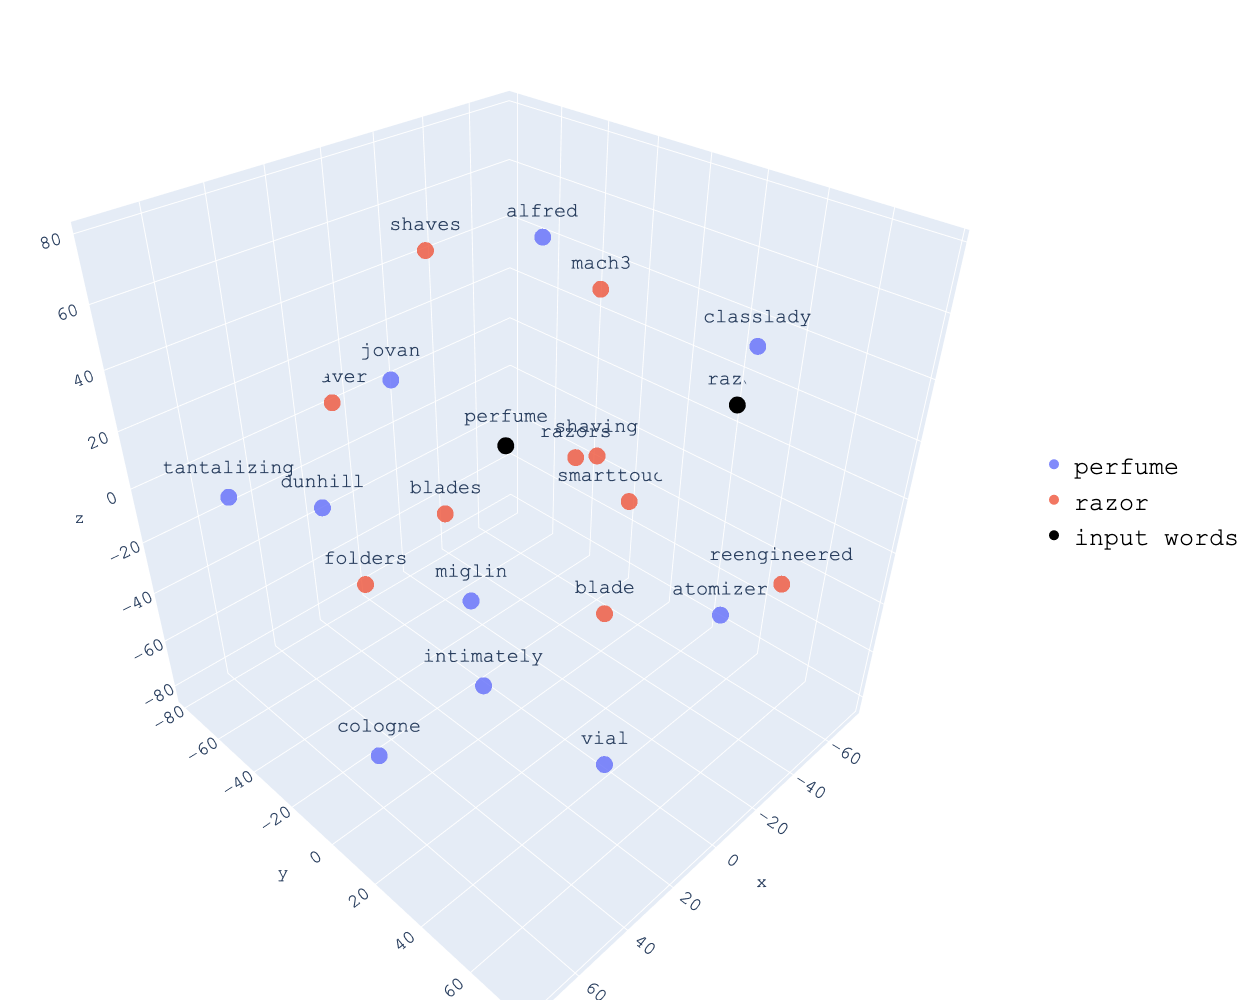

In [58]:
display_tsne_scatterplot_3D(google_model, user_input , similar_word, labels, color_map)

The input words for comparison are "perfume" and "mask"
In the word embeddings visualization above, it shows how similar words are clustered around the input word.


### Word2Vec Model

In [17]:
def is_word_in_model(word, model):
    """
    Check on individual words ``word`` that it exists in ``model``.
    """
    assert type(model).__name__ == 'KeyedVectors'
    is_in_vocab = word in model.key_to_index.keys()
    return is_in_vocab

def predict(query_sentence, dataset, model, topk=5):
    query_sentence = query_sentence.split()
    in_vocab_list, best_index = [], [0]*topk
    for w in query_sentence:
        # remove unseen words from query sentence
        if is_word_in_model(w, model.wv):
            in_vocab_list.append(w)
    # Retrieve the similarity between two words as a distance
    if len(in_vocab_list) > 0:
        sim_mat = np.zeros(len(dataset))  # TO DO
        for i, sentence in enumerate(dataset):
            if sentence:
                sim_sentence = model.wv.n_similarity(
                        in_vocab_list, sentence)
            else:
                sim_sentence = 0
            sim_mat[i] = np.array(sim_sentence)
        # Take the five highest norm
        best_index = np.argsort(sim_mat)[::-1][:topk]
    return best_index

#### Test user input: "bottle of perfume"

In [46]:
test = "mask"
best_index = predict(test, corpus, google_model)    
display(df[['product', 'brand', 'price','review', 'average_reviewer_score', 'imageURLHighRes']].iloc[best_index])

,product,brand,price,review,average_reviewer_score,imageURLHighRes
productID,,,,,,
B000142UBC,Maggot Buffet Mask,,,I have tried many different toners before. Mo...,5.0,[https://images-na.ssl-images-amazon.com/image...
B012LY1SCQ,Elvira Sleep Mask,Kreepsville,$11.99,I love it fits great and stays on the whole night,4.88,[https://images-na.ssl-images-amazon.com/image...
B00L2C9GR8,Sleep Mask (sleep mask x10),BFlowerYan,,Good for the price. The dual elastic straps an...,4.0,[https://images-na.ssl-images-amazon.com/image...
B0069SO08A,Charcoal Magic Mask!,,,I really wanted to like this product but the p...,3.5,[https://images-na.ssl-images-amazon.com/image...
B01HEC4UDO,Lavina Essence Mask Sheet,,,I want to preface this by saying that the cust...,2.0,[https://images-na.ssl-images-amazon.com/image...


#### Convert the column "average_reviewer_score" to a string type for deployment on streamlit

In [19]:
df['average_reviewer_score'] = round(df['average_reviewer_score'],2)

In [20]:
df['average_reviewer_score'] = df['average_reviewer_score'].astype(str)

In [21]:
#Save the model
filename = 'model/word2vec_model.sav'
pickle.dump(google_model, open(filename, 'wb'))

In [22]:
#Pickle df
df.to_pickle('dataset/df_for_deployment.pkl')

# Conclusion

#### **Limitations** 

This project is entirely run on a M1 Macbook, hence one of the biggest limiatations will be computing efficiency. As the Amazon product dataframe contains over 300,000 rows of data, applying higher level NLP techniques like BERT will be challenging.

#### **Comparing the TF-IDF vs Word2vec**

It is observed that for the TF-IDF + Cosine Similarity model, the top 5 recommendations more often than not will contain the keywords that are inputted by the user. For example, when "bottle of perfume" is inputted, the top 5 recommendations doesn't contain any products relating to "perfume".

**TF-IDF Bag of words**

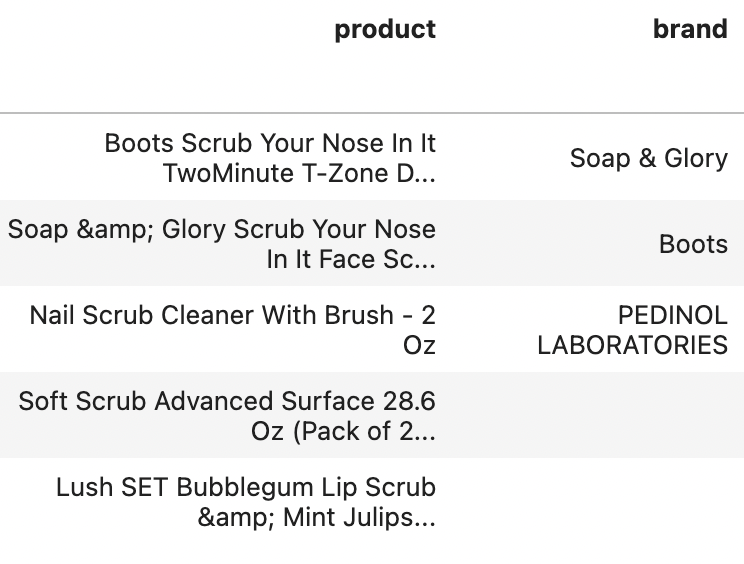

**Word2vec** 

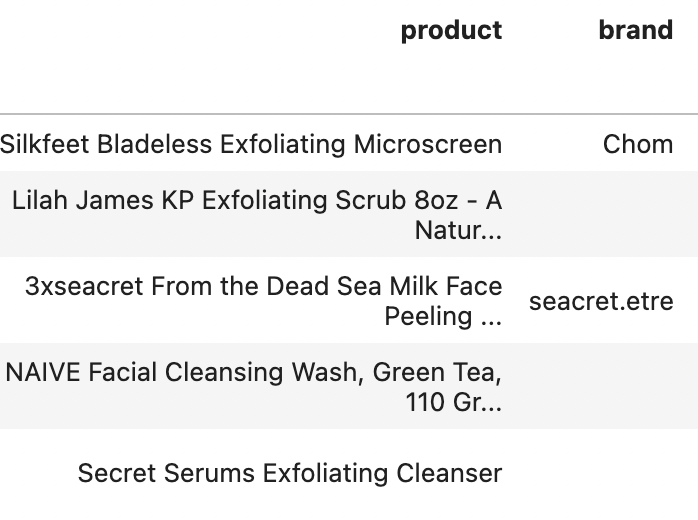


As observed in the comparison of the same text input, **"scrub"**, the TF-IDF model contains recommendations that have the word "scrub" in their product description. This means that the recommendations provided by the TF-IDF model is limited to the users inputing the exact right keyword for their search.
The Word2vec model is able to capture the input sentence semantics and able to recommend products without the word "scrub" in it and recommend products with the similar words like "exfoliating", "peeling", "cleansing".

**Advantages of the TF-IDF + Cosine Similarity Model**
- Fast deployment
- Works well with small dataset
- Suitable to be used as a baseline model for a content based recommendations system

**Disadvantages of the TF-IDF + Cosine Similarity Model**
- More advance tehniques like word embeddings Word2vec and BERT will outperform this model

**Advantages of the Word2vec + Cosine Similarity Model**
- With pretrained Word2vec models already available, training a new corpus is easy and fast
- Word2vec transforms the unlabled raw corpus into labeled data (by mapping the target word to its context word), and learns the representation of words in a classification task
- The mapping between the target word to its context word implicitly embeds the sub-linear relationship into the vector space of words, so that relationships like “king:man as queen:woman” can be infered by word vectors

**Disadvantages of the Word2vec + Cosine Similarity Model**
- Inability to handle unknown or out-of-vocabulary (OOV) words. If the model hasn't encountered a word before, it will have no idea how to interpret it or how to build a vector for it
- Ability to seperate opposite words. For example, “good” and “bad” are usually located very close to each other in the vector space, which may limit the performance of word vectors in NLP tasks like sentiment analysis.

#### In conclusion, the Word2vec model is more relevant in accordance to this project's scope. As such, we will proceed to delpoy this model to streamlit.

# Future Works

This project only used the data of Amazon Beauty Products. Out of 371,345 rows of data, there are only 295,217 unique users. Which translates to most of our users are only leaving 1 review. **However, there is a huge possibility that those users have left reviews in other categories.** 

For future works, **we can utilise the datasets of other categories and find out what the users have purchased previously before. We can then proceed to build a collaborative filtering recommendation system**. Doing this will mean that the amount of data to process will be a lot larger than the data used in this project.

We can then build a more wholesome recommendation system that encompass all the other categories. The Word2vec model will perform better too with the larger corpus available to train on and obtain the word embeddings. 

**More advance techniques**
- BERT4Rec:Sequential Recommendation with Bidirectional Encoder Representations from Transformer

chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/1904.06690.pdf